In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py 
from scipy import stats
from scipy.optimize import minimize

from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error as mse

import matplotlib.mlab as mlab
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from   torch.autograd import Variable

import os


%matplotlib inline

In [3]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [5]:
file_location = '/mnt/home/warshadcheema/xfel_data.h5'
labels = pd.read_hdf(file_location, key= 'new')
all_data = pd.read_hdf(file_location, key= 'df')

In [6]:
labels.shape

(60656, 8)

In [7]:
all_data.shape

(60656, 352)

In [8]:
cols=[]
for i in range(230):
    temp="intensity_photon_energy_%d" %i
    cols.append(temp)
for i in range(64):
    temp="intensity_time_%d" %i
    cols.append(temp)
# print(cols)
more = ['experiment_id','intensity_photon_energy_mean',
       'intensity_photon_energy_std', 'intensity_time_mean',
       'intensity_time_std']
features=all_data.drop(cols,axis=1)
features=features.drop(more,axis=1)
features = features.astype(float)
# print(features.columns)


In [9]:
class XFELDataset(Dataset):
    def __init__(self):
       
        # Calculate len
        self.data_len = features.shape[0]

#         # set attributes and labels
        self.attributes = features.values
        self.labels= labels.values

    def __getitem__(self, index):
              
        # Get attributes
        get_attribute = torch.tensor((self.attributes[index,:]),dtype=torch.float32)
        #get Labels
        get_label = torch.tensor((self.labels[index,:]),dtype=torch.float32)
#         if index == 0:
#             print("attr shape:", get_attribute.size())
#             print("label shape:", get_label.size())
        return get_attribute, get_label 

    def __len__(self):
        return self.data_len

In [10]:
class GenHelper(Dataset):
    def __init__(self, mother, length, mapping):
        # here is a mapping from this index to the mother dataset index
        self.mapping=mapping
        self.length=length
        self.mother=mother

    def __getitem__(self, index):
        return self.mother[self.mapping[index]]

    def __len__(self):
        return self.length


def train_test_split(dataset, split_fold=10, random_seed=None):
    '''
    This is a pytorch generic function that takes a data.Dataset object and splits it to training and testing
    efficiently.
    :return:
    '''
    if random_seed == None:    
        np.random.seed(random_seed)

    dataset_length=dataset.__len__()
    indices=list(range(dataset_length))
    test_size=dataset_length//split_fold
    np.random.shuffle(indices)
    train_mapping=indices[test_size:]
    test_mapping=indices[:test_size]
    train_set=GenHelper(dataset, dataset_length - test_size, train_mapping)
    test_set=GenHelper(dataset, test_size, test_mapping)

    return train_set, test_set

In [11]:
data=XFELDataset() 
print(data.__len__())
train_set,test_set=train_test_split(data,10)
print(len(train_set))
print(len(test_set))

60656
54591
6065


In [12]:
batch_size=100

In [13]:
train_loader = torch.utils.data.DataLoader(dataset = train_set,batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_set, batch_size = batch_size, shuffle = False)

In [14]:
class AutoEncoder(nn.Module):
    
    def __init__(self, code_size):
        super().__init__()
        self.code_size = code_size
        
        # Encoder specification
        self.enc1 = nn.Linear(code_size, 25)
        self.enc2 = nn.Linear(25, 15)
        
        # Decoder specification
        self.dec1 = nn.Linear(15, 25)
        self.dec2 = nn.Linear(25, code_size)
        
    def forward(self, x):
        code = self.encode(x)
        out = self.decode(code)
        return out, code
    
    def encode(self, inc):
        code = self.enc1(inc)
        code = self.enc2(code)
        return code
    
    def decode(self, code):
        out = self.dec1(code)
        out = self.dec2(out)
        return out
    


In [15]:
code_size = 53
num_epochs = 50

lr = 0.002
optimizer_cls = optim.Adam

In [16]:
# Instantiate model
autoencoder = AutoEncoder(code_size)
loss_fn = nn.MSELoss()
optimizer = optimizer_cls(autoencoder.parameters(), lr=lr)

In [ ]:
# Training loop
for epoch in range(num_epochs):
    print("Epoch %d" % epoch)
# Ignore image labels
    for batch_idx, (inputs, target)in enumerate(train_loader):    
        
        out, code = autoencoder(inputs)
#         print(out)
#         print(inputs)
        
        optimizer.zero_grad()
        loss = loss_fn(inputs, out)
        loss.backward()
        optimizer.step()
        
    print("Loss = %.3f" % loss.item())

In [19]:
class LinearNet(nn.Module):
    def __init__(self):
        super(LinearNet, self).__init__()
        self.fc1 = nn.Linear(53, 100)
        self.fc2 = nn.Linear(100, 30)
        self.fc3 = nn.Linear(30, 8)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [20]:
num_epochs = 300
learning_rate =0.001

In [21]:
criterion = nn.MSELoss()
net=LinearNet().to(device)
# net = Xfel()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [22]:
def train_nn(net,train_loader,i):
    train_loss=0
# create a loss function
    for batch_idx, (inputs, target) in enumerate(train_loader):
        inputs = autoencoder.forward(inputs)
#         print(type(inputs[0]))
#         if batch_idx % 100 == 0:
#             print ("batch_id: ", batch_idx, inputs.size(), target.size())
        inputs, target = inputs[0].to(device), target.to(device)
        
        optimizer.zero_grad()
        net_out = net.forward(inputs)
        loss = criterion(net_out, target)
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()
    train_loss /= (len(train_loader.dataset)/batch_size)
    print("epoch" , i+1 ," loss: ", train_loss)
    return (train_loss)

In [ ]:
for i in range(num_epochs):
    train_nn(net,train_loader,i)
print("Trainning finished")

In [24]:
def test_nn (net,test_loader):
    predicted_intensities=[]
    target_intensities=[]
    with torch.no_grad():
        for batc_idx, (inputs,target) in enumerate(test_loader):
#             print(inputs.size())
#             print(inputs)
#             inputs0, code = autoencoder(inputs)
#             inputs = inputs0
            inputs, target = inputs.to(device), target.to(device)
            
            net_out = np.asarray(net.forward(inputs).cpu())
#             print(net_out)
            if batc_idx==0:
                predicted_intensities = net_out
                target_intensities = target.cpu()
            predicted_intensities = np.append(predicted_intensities, net_out, axis=0)
            target_intensities = np.append(target_intensities, target.cpu(), axis=0)
    
    print(predicted_intensities.shape)
    print(target_intensities.shape)
    return predicted_intensities, target_intensities

In [25]:
predicted_intensities, target_intensities = test_nn(net, test_loader)
predicted_intensities

(6165, 8)
(6165, 8)


array([[ 11.527087, 119.82773 , 119.773705, ...,  32.443516,  32.197304,
          4.594804],
       [ 11.527087, 119.82773 , 119.773705, ...,  32.443516,  32.197304,
          4.594804],
       [ 11.527087, 119.82773 , 119.773705, ...,  32.443516,  32.197304,
          4.594804],
       ...,
       [ 11.527087, 119.82773 , 119.773705, ...,  32.443516,  32.197304,
          4.594804],
       [ 11.527087, 119.82773 , 119.773705, ...,  32.443516,  32.197304,
          4.594804],
       [ 11.527087, 119.82773 , 119.773705, ...,  32.443516,  32.197304,
          4.594804]], dtype=float32)

In [26]:
mse = (np.square(predicted_intensities - target_intensities)).mean()
mse

54.622395

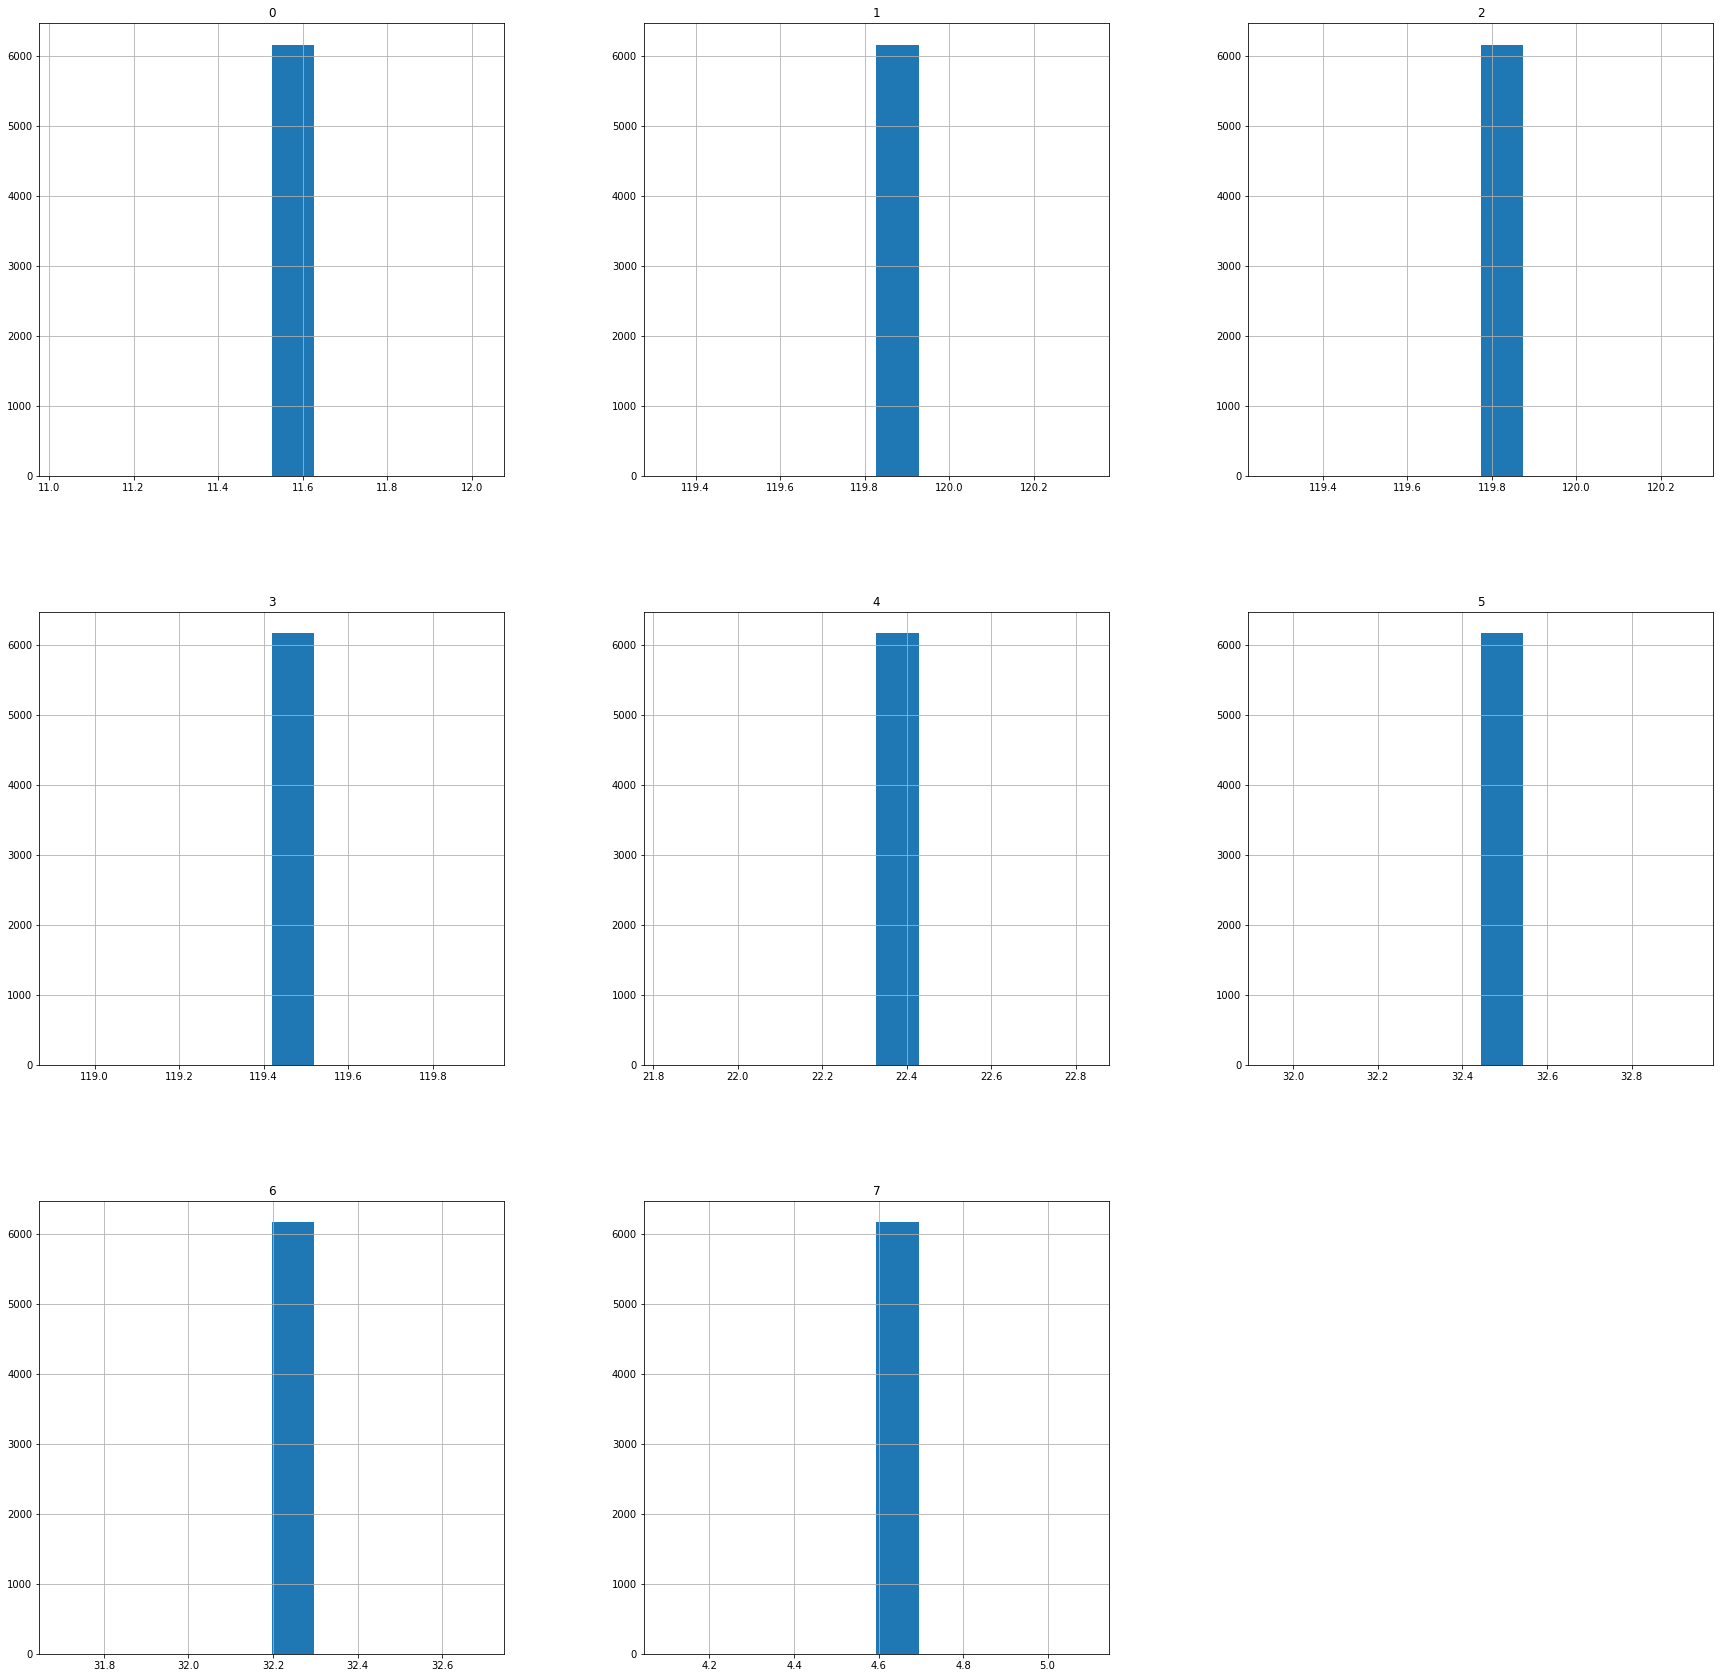

In [28]:
pred_df = pd.DataFrame(predicted_intensities)
pred_df.hist(figsize=(30, 30))
plt.show()